In [ ]:
"""
Purpose: To decompose the multi-somas for splitting
using the new decomposition method



"""

In [1]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/")

import datajoint_utils as du
from importlib import reload

INFO - 2021-01-28 21:51:34,720 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-01-28 21:51:34,721 - settings - Setting database.user to celiib
INFO - 2021-01-28 21:51:34,722 - settings - Setting database.password to newceliipass
INFO - 2021-01-28 21:51:34,727 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO - 2021-01-28 21:51:34,728 - settings - Setting enable_python_native_blobs to True
INFO - 2021-01-28 21:51:34,741 - connection - Connect

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2021-01-28 21:51:35,016 - settings - Setting enable_python_native_blobs to True


In [2]:
#so that it will have the adapter defined
from datajoint_utils import *

In [3]:
test_mode = True

# Debugging the contains method

In [4]:
import system_utils as su

In [5]:
import minfig
import time
import numpy as np
#want to add in a wait for the connection part
random_sleep_sec = np.random.randint(0, 200)
print(f"Sleeping {random_sleep_sec} sec before conneting")
if not test_mode:
    time.sleep(random_sleep_sec)
print("Done sleeping")

du.config_celii()
du.set_minnie65_config_segmentation(minfig)
du.print_minnie65_config_paths(minfig)

#configuring will include the adapters
minnie,schema = du.configure_minnie_vm()

INFO - 2021-01-28 21:51:35,073 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-01-28 21:51:35,073 - settings - Setting database.user to celiib
INFO - 2021-01-28 21:51:35,074 - settings - Setting database.password to newceliipass
INFO - 2021-01-28 21:51:35,078 - settings - Setting enable_python_native_blobs to True


Sleeping 95 sec before conneting
Done sleeping
Current path for external_segmentation_path = /mnt/dj-stor01/platinum/minnie65/02
Current path for external_mesh_path = /mnt/dj-stor01/platinum/minnie65/02/meshes
Current path for external_decimated_mesh_path = /mnt/dj-stor01/platinum/minnie65/02/decimated_meshes
Current path for external_skeleton_path = /mnt/dj-stor01/platinum/minnie65/02/skeletons


INFO - 2021-01-28 21:51:35,362 - settings - Setting enable_python_native_blobs to True


# Defining the Table

In [6]:
import neuron_utils as nru
import neuron
import trimesh_utils as tu
import numpy as np

In [7]:
import meshlab
meshlab.set_meshlab_port(current_port=None)

No port chosen so picked random port 1022


In [ ]:
# minnie.DecompositionSplit.drop()
# schema.external['decomposition'].delete(delete_external_files=True)

In [9]:
import numpy as np
import time
import proofreading_utils as pru

max_n_somas=8
split_version = 0

verbose = True

@schema
class DecompositionSplit(dj.Computed):
    definition="""
    -> minnie.Decomposition()
    split_index: tinyint unsigned  #the index of the neuron object that resulted AFTER THE SPLITTING ALGORITHM
    split_version: tinyint unsigned  #the version of the splitting algorithm used
    ---
    multiplicity=null    : tinyint unsigned             # the number of somas found for this base segment
    n_splits             : int unsigned                 # the number of cuts required to help split the neuron
    split_success        : tinyint unsigned             # the successfulness of the splitting
    
    n_error_limbs_cancelled : tinyint unsigned     # number of limbs that couldn't be resolved and cancelled out        
    n_same_soma_limbs_cancelled : tinyint unsigned     # number of same soma touching limbs that couldn't be resolved and cancelled out
    n_multi_soma_limbs_cancelled : tinyint unsigned     # number of multi soma touching limbs that couldn't be resolved and cancelled out        
    
    error_imbs_cancelled_area=NULL : double            # the total area (in microns^2) of the limbs that was cancelled out because touching the same soma multiple times or multiple somas
    error_imbs_cancelled_skeletal_length = NULL : double #the total skeletal length (in microns) of the limbs that were called out because could not be resolved
    
    split_results: longblob #will store the results of how to split the limbs of neuron objects from original neuron
    decomposition: <decomposition>
    n_vertices           : int unsigned                 # number of vertices
    n_faces              : int unsigned                 # number of faces
    n_not_processed_soma_containing_meshes : int unsigned  #the number of meshes with somas that were not processed
    n_error_limbs: int #the number of limbs that are touching multiple somas or 1 soma in multiple places
    n_same_soma_multi_touching_limbs: int # number of limbs that touch the same soma multiple times
    n_multi_soma_touching_limbs: int # number of limbs that touch multiple somas
    n_somas: int #number of soma meshes detected
    max_soma_n_faces:  int unsigned                 # The largest number of faces of the somas
    max_soma_volume:  int unsigned                 # The largest volume of the somas the (volume in billions (10*9 nm^3))
    n_limbs: int
    n_branches: int
    max_limb_n_branches=NULL:int
    
    skeletal_length=NULL: double
    max_limb_skeletal_length=NULL:double
    median_branch_length=NULL:double #gives information on average skeletal length to next branch point
    
    
    width_median=NULL: double #median width from mesh center without spines removed
    width_no_spine_median=NULL: double #median width from mesh center with spines removed
    width_90_perc=NULL: double # 90th percentile for width without spines removed
    width_no_spine_90_perc=NULL: double  # 90th percentile for width with spines removed
    
    
    n_spines: bigint

    spine_density=NULL: double # n_spines/ skeletal_length
    spines_per_branch=NULL: double
    
    skeletal_length_eligible=NULL: double # the skeletal length for all branches searched for spines
    n_spine_eligible_branches=NULL: int # the number of branches that were checked for spines because passed width threshold
    
    spine_density_eligible=NULL:double # n_spines/skeletal_length_eligible
    spines_per_branch_eligible=NULL:double # n_spines/n_spine_eligible_branches
    
    total_spine_volume=NULL: double # the sum of all spine volume
    spine_volume_median=NULL: double # median of the spine volume for those spines with able to calculate volume
    spine_volume_density=NULL: double #total_spine_volume/skeletal_length
    spine_volume_density_eligible=NULL: double #total_spine_volume/skeletal_length_eligible
    spine_volume_per_branch_eligible=NULL: double #total_spine_volume/n_spine_eligible_branches
    
    run_time=NULL : double                   # the amount of time to run (seconds)

    
    """
                             
    
    ''' Old keysource used for inhibitory excitatory check
    classified_table = (minnie.BaylorManualCellType() &
                        'nucleus_version=3' & 
                        "(cell_type = 'excitatory') or  (cell_type = 'inhibitory')")
    
    key_source = ((minnie.Decomposition & 
                (minnie.NeuronSplitSuggestions.proj()) & 
                (classified_table.proj()) 
                & f"n_somas<{max_n_somas}" & "n_error_limbs>0"))'''
    
    # This keysource acounts that you could have more than 1 possible soma but not a significant limb connecting them (no error limbs)
    key_source = minnie.Decomposition() & "n_somas>1 OR n_error_limbs>0"
    
    

    def make(self,key):
        """
        Pseudocode for process:

        1) Get the segment id from the key
        2) Get the decomposed neurong object from Decomposition table
        3) Run the multi_soma split suggestions algorithm
        4) Get the number of splits required for this neuron
        5) Split the neuron into a list of neuron objects
        6) For each neuron object in the list:
        - get the number of errored limbs (to indicate the success type)
        - Change the description to include the multiplicity
        - Compute the information on the largest soma faces and volume
        - Save the neuron object to the external
        - Add the new write key to a list to commit 
        7) Write all of the keys 
        """
        
        whole_pass_time = time.time()
        
        
        
        # 1) Get the segment id from the key
        segment_id = key["segment_id"]
        print(f"\n\n\n---- Working on Neuron {key['segment_id']} ----")
        
        
        # 2) Get the decomposed neuron object from Decomposition table and the split suggestions
        neuron_obj = (minnie.Decomposition & key).fetch1("decomposition")
        
        """ Old way that downloaded from another table
        # 3) Retrieve the multi soma suggestions
        split_results = (minnie.NeuronSplitSuggestions & key).fetch1("split_results")
        """
        #3) Calculated the split results
        split_results = pru.multi_soma_split_suggestions(neuron_obj,plot_intermediates=False)
        
        # 4) Get the number of splits required for this neuron
        n_paths_cut = pru.get_n_paths_cut(split_results)

        if verbose:
            print(f"n_paths_cut = {n_paths_cut}")
            
            
        # 5) Split the neuron into a list of neuron objects
        (neuron_list,
        neuron_list_errored_limbs_area,
         neuron_list_errored_limbs_skeletal_length,
        neuron_list_n_multi_soma_errors,
        neuron_list_n_same_soma_errors) = pru.split_neuron(neuron_obj,
                        limb_results=split_results,
                                       verbose=verbose,
                                        return_error_info=True
                                            )
        
        print(f"neuron_list = {neuron_list}")
        print(f"neuron_list_errored_limbs_area = {neuron_list_errored_limbs_area}")
        print(f"neuron_list_n_multi_soma_errors = {neuron_list_n_multi_soma_errors}")
        print(f"neuron_list_n_same_soma_errors = {neuron_list_n_same_soma_errors}")
        
        
        if verbose:
            print(f"Number of neurons: {len(neuron_list)}")
        
        neuron_entries = []
        for neuron_idx in range(len(neuron_list)):
            
            """
            # 6) For each neuron object in the list:
            # - get the number of errored limbs (to indicate the success type)
            # - Compute the information on the largest soma faces and volume
            # - Save the neuron object to the external
            # - Add the new write key to a list to commit 
            """
            n = neuron_list[neuron_idx]
            
            error_imbs_cancelled_area = neuron_list_errored_limbs_area[neuron_idx]
            error_imbs_cancelled_skeletal_length = neuron_list_errored_limbs_skeletal_length[neuron_idx]
            n_multi_soma_limbs_cancelled = neuron_list_n_multi_soma_errors[neuron_idx]
            n_same_soma_limbs_cancelled = neuron_list_n_same_soma_errors[neuron_idx]
            
            
            #for n in neuron_list:
            #     nviz.visualize_neuron(n,
            #                          limb_branch_dict="all")

            # - get the number of errored limbs (to indicate the success type)
            if n.n_error_limbs == 0:
                split_success = 0
            elif n.multi_soma_touching_limbs == 0:
                split_successs = 1
            elif n.same_soma_multi_touching_limbs == 0:
                split_success = 2
            else:
                split_success = 3

            if verbose:
                print(f"split_success = {split_success}")

            # - Compute the information on the largest soma faces and volume
            soma_volumes = [n[k].volume/1000000000 for k in n.get_soma_node_names()] 
            soma_n_faces = [len(n[k].mesh.faces) for k in n.get_soma_node_names()] 

            largest_n_faces = np.max(soma_n_faces)
            largest_volume = np.max(soma_volumes)

            if verbose:
                print(f"largest_n_faces = {largest_n_faces}")
                print(f"largest_volume = {largest_volume}")


            #6) Save the file in a certain location
            if True:
                save_time = time.time()
                ret_file_path = n.save_compressed_neuron(output_folder=str(du.get_decomposition_path()),
                                                  return_file_path=True,
                                                 export_mesh=False,
                                                 suppress_output=True)

                ret_file_path_str = str(ret_file_path.absolute()) + ".pbz2"
                print(f"Save time = {time.time() - save_time}")
            else:
                ret_file_path_str = "dummy_holder"



            #7) Pass stats and file location to insert
            new_key = dict(key,
                           split_index = neuron_idx,
                           split_version = split_version,
                           
                           multiplicity=len(neuron_list),

                           n_splits = n_paths_cut,
                           split_success = split_success,
                           
                           n_error_limbs_cancelled = len(error_imbs_cancelled_area),
                           
                           n_multi_soma_limbs_cancelled =n_multi_soma_limbs_cancelled,
                           n_same_soma_limbs_cancelled = n_same_soma_limbs_cancelled,
                           error_imbs_cancelled_area = np.round(np.sum(error_imbs_cancelled_area),4),
                           error_imbs_cancelled_skeletal_length = np.round(np.sum(error_imbs_cancelled_skeletal_length)/1000,4),
                           
                           split_results=split_results,

                           max_soma_n_faces = largest_n_faces,
                           max_soma_volume = largest_volume,


                           decomposition=ret_file_path_str,
                           n_vertices=len(n.mesh.vertices),
                           n_faces=len(n.mesh.faces),
                           run_time=np.round(time.time() - whole_pass_time,4)
                          )

            stats_dict = n.neuron_stats()
            new_key.update(stats_dict)


            neuron_entries.append(new_key)

        
        self.insert(neuron_entries, allow_direct_insert=True, skip_duplicates=True)

        print(f"\n\n ------ Total time for {segment_id} = {time.time() - whole_pass_time} ------")
    

# Running the Populate

In [11]:
curr_table = (minnie.schema.jobs & "table_name='__decomposition_split'")
(curr_table).delete()# & "status='error'")
#curr_table.delete()
#(curr_table & "error_message = 'ValueError: need at least one array to concatenate'").delete()

In [13]:
DecompositionSplit()

segment_id segment id unique within each Segmentation,decimation_version,decimation_ratio ratio of remaining mesh vertices/faces (which ones depends on what metric the decimation technique uses),ver the version number of the materializaiton,process_version the version of the preprocessing pipeline run,index the index of the neuron object that resulted from that mesh (indexed starting at 0),split_index the index of the neuron object that resulted AFTER THE SPLITTING ALGORITHM,split_version the version of the splitting algorithm used,multiplicity the number of somas found for this base segment,n_splits the number of cuts required to help split the neuron,split_success the successfulness of the splitting,n_error_limbs_cancelled number of limbs that couldn't be resolved and cancelled out,n_same_soma_limbs_cancelled number of same soma touching limbs that couldn't be resolved and cancelled out,n_multi_soma_limbs_cancelled number of multi soma touching limbs that couldn't be resolved and cancelled out,error_imbs_cancelled_area the total area (in microns^2) of the limbs that was cancelled out because touching the same soma multiple times or multiple somas,error_imbs_cancelled_skeletal_length the total skeletal length (in microns) of the limbs that were called out because could not be resolved,split_results will store the results of how to split the limbs of neuron objects from original neuron,decomposition,n_vertices number of vertices,n_faces number of faces,n_not_processed_soma_containing_meshes the number of meshes with somas that were not processed,n_error_limbs the number of limbs that are touching multiple somas or 1 soma in multiple places,n_same_soma_multi_touching_limbs number of limbs that touch the same soma multiple times,n_multi_soma_touching_limbs number of limbs that touch multiple somas,n_somas number of soma meshes detected,max_soma_n_faces The largest number of faces of the somas,max_soma_volume The largest volume of the somas the (volume in billions (10*9 nm^3)),n_limbs,n_branches,max_limb_n_branches,skeletal_length,max_limb_skeletal_length,median_branch_length gives information on average skeletal length to next branch point,width_median median width from mesh center without spines removed,width_no_spine_median median width from mesh center with spines removed,width_90_perc 90th percentile for width without spines removed,width_no_spine_90_perc 90th percentile for width with spines removed,n_spines,spine_density n_spines/ skeletal_length,spines_per_branch,skeletal_length_eligible the skeletal length for all branches searched for spines,n_spine_eligible_branches the number of branches that were checked for spines because passed width threshold,spine_density_eligible n_spines/skeletal_length_eligible,spines_per_branch_eligible n_spines/n_spine_eligible_branches,total_spine_volume the sum of all spine volume,spine_volume_median median of the spine volume for those spines with able to calculate volume,spine_volume_density total_spine_volume/skeletal_length,spine_volume_density_eligible total_spine_volume/skeletal_length_eligible,spine_volume_per_branch_eligible total_spine_volume/n_spine_eligible_branches,run_time the amount of time to run (seconds)
864691134589113354,0,0.25,30.00,0,0,0,0,1,0,0,0,0,0,0.0,0.0,=BLOB=,=BLOB=,7186,12767,0,0,0,0,1,10459,239,1,1,1,6500.555290747829,6500.555290747829,6500.555,81.132,81.132,81.132,81.132,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.9611
864691134651920138,0,0.25,30.00,0,0,0,0,1,1,0,0,0,0,0.0,0.0,=BLOB=,=BLOB=,9198,18376,0,0,0,0,1,15669,116,2,2,1,6822.182041214921,3523.999859732133,3411.091,32.65,32.65,37.472,37.472,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.6076
864691134668951908,0,0.25,30.00,0,0,0,0,1,0,0,0,0,0,0.0,0.0,=BLOB=,=BLOB=,8375,16983,0,0,0,0,1,10968,73,1,3,3,30717.021602829212,30717.021602829212,11655.34,55.344,55.344,99.027,99.027,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.4635
864691134691461988,0,0.25,30.00,0,0,0,0,1,0,0,0,0,0,0.0,0.0,=BLOB=,=BLOB=,27

Populate Started


INFO - 2021-01-28 21:51:56,785 - autopopulate - Found 16807 keys to populate
INFO - 2021-01-28 21:51:56,796 - connection - Transaction started
INFO - 2021-01-28 21:51:56,798 - autopopulate - Populating: {'segment_id': 864691134589113354, 'decimation_version': 0, 'decimation_ratio': Decimal('0.25'), 'ver': Decimal('30.00'), 'process_version': 0, 'index': 0}





---- Working on Neuron 864691134589113354 ----
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = []
n_paths_cut = 0
using precomputed split suggestions


------ Working on Soma 0 -------
limb_neighbors BEFORE error limbs removed = [0]
limb_neighbors AFTER error limbs removed = [0]
curr_n_multi_soma_limbs_cancelled = 0
curr_n_same_soma_limbs_cancelled = 0
n_errored_lims = 0
curr_error_limbs_cancelled_area = []
local_floating_meshes = []
Already have preprocessed data
--- 1) Finished unpacking preprocessed materials: 5.125999450683594e-05
total_edges = [['S0', 'L0']]
--- 2) Finished creating neuron connectivity graph: 9.703636169433594e-05
Having to generate soma_meshes_face_idx because none in preprocessed data
--- 3a) Finshed generating soma_meshes_face_idx: 0.003877878189086914
Using precomputed volume ratio
--- 3) Finshed generating soma objects and adding them to concept graph: 6.572812557220459
Using already existing limb_mehses_

  Edge: [1 2]: curr_angle = 159.3

Total time for doubling_back = 0.026336669921875
There were 1 edges that passed doubling back threshold of 80
Winning edge [1 2] had a doubling back of 159.30416655614198
***inside resolve crossover!!!!****
coordinate_branches = [0, 1, 2]
0 = red
1 = aqua
2 = purple
Angle between 0 and 1 = 36.77 
Angle between 0 and 2 = 56.47 
Angle between 1 and 2 = 159.3 
Final Matches = []
matched_branches_revised = []
Original graph


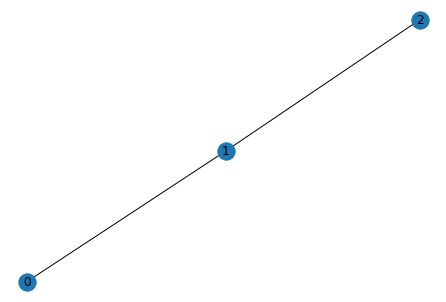

match_branches = []
edges_to_delete (resolve crossover) = [[0, 1], [0, 2], [1, 2]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([0, 1]), array([0, 2]), array([1, 2])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {2}
Comp 1 = {0}
Comp 2 = {1}
curr_limb_copy.deleted_edges = [array([0, 1]), array([0, 2]), array([1, 2])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([0, 1]), array([0, 2]), array([1, 2])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 3: [array([2]), array([0]), array([1])]
n_paths_cut = 1
using precomputed split suggestions


---Working on Splitting Limb 0 with 3 components----


----Working on seperate_

Total time for neuron instance creation = 6.563706636428833


Number of seperate neuron objects = 1
neuron_list = [<neuron.Neuron object at 0x7fedfd2fe940>]
neuron_list_errored_limbs_area = [[]]
neuron_list_n_multi_soma_errors = [0]
neuron_list_n_same_soma_errors = [0]
Number of neurons: 1
split_success = 0
largest_n_faces = 11571
largest_volume = 109.36941543291621
Saving Neuorn in suppress_output mode...please wait
Saved File at location: /mnt/dj-stor01/platinum/minnie65/02/decomposition/864691134691461988_0_25_soma_0_split
Save time = 0.32924437522888184


 ------ Total time for 864691134691461988 = 16.249444246292114 ------



---- Working on Neuron 864691134743737238 ----
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = [1]


 -------- Working on limb 1------------
Starting combinations to process = [[0 1]
 [0 2]
 [1 2]]


---- working on disconnecting 0 and 1
---- This disconnects S0_1 from S0_2  
 Cut iteration 0
Total number of

  Edge: [0 1]: curr_angle = 98.79

Total time for doubling_back = 0.03634786605834961
There were 1 edges that passed doubling back threshold of 80
Winning edge [0 1] had a doubling back of 98.78684867742226
***inside resolve crossover!!!!****
coordinate_branches = [0, 1, 2]
0 = red
1 = aqua
2 = purple
Angle between 0 and 1 = 70.76 
Angle between 0 and 2 = 116.24 
Angle between 1 and 2 = 110.54 
Final Matches = []
matched_branches_revised = []
Original graph


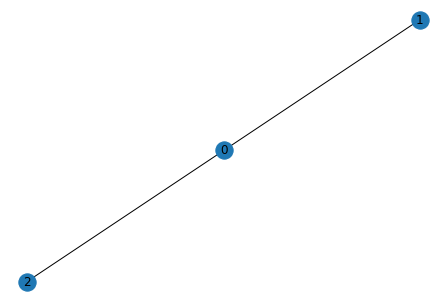

match_branches = []
edges_to_delete (resolve crossover) = [[0, 1], [0, 2], [1, 2]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([0, 1]), array([0, 2]), array([1, 2])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {2}
Comp 1 = {0}
Comp 2 = {1}
curr_limb_copy.deleted_edges = [array([0, 1]), array([0, 2]), array([1, 2])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([0, 1]), array([0, 2]), array([1, 2])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection


---- working on disconnecting 0 and 2
---- This disconnects S0_1 from S0_0  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIR

local_floating_meshes = [<trimesh.Trimesh(vertices.shape=(520, 3), faces.shape=(922, 3))>]
Already have preprocessed data
--- 1) Finished unpacking preprocessed materials: 5.6743621826171875e-05
total_edges = [['S0', 'L0']]
--- 2) Finished creating neuron connectivity graph: 9.846687316894531e-05
Having to generate soma_meshes_face_idx because none in preprocessed data
--- 3a) Finshed generating soma_meshes_face_idx: 0.007827043533325195
Using precomputed volume ratio
--- 3) Finshed generating soma objects and adding them to concept graph: 6.420402765274048
Using already existing limb_mehses_face_idx in preprocessed data 
curr_limb_concept_networks= {0: [<networkx_utils.GraphOrderedEdges object at 0x7fedf7ad2400>]}
--- 4) Finshed generating Limb objects and adding them to concept graph: 0.023828506469726562
--- 5) SKIPPING Doing the adaptive mesh correspondence on the meshparty preprocessing ---
--- 6) SKIPPING Using the computed_attribute_dict to populate neuron attributes ---
self.n_


Total time for neuron instance creation = 7.741178750991821


Number of seperate neuron objects = 1
neuron_list = [<neuron.Neuron object at 0x7fedfc0b4c50>]
neuron_list_errored_limbs_area = [[55.58403907745735]]
neuron_list_n_multi_soma_errors = [0]
neuron_list_n_same_soma_errors = [1]
Number of neurons: 1
split_success = 0
largest_n_faces = 9377
largest_volume = 0.0
Saving Neuorn in suppress_output mode...please wait
Saved File at location: /mnt/dj-stor01/platinum/minnie65/02/decomposition/864691134743737238_0_25_soma_0_split
Save time = 0.1414623260498047


 ------ Total time for 864691134743737238 = 16.002374172210693 ------



---- Working on Neuron 864691134765143804 ----
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = [0]
multi_touch_limbs = []


 -------- Working on limb 0------------
Starting combinations to process = []
Total number of graphs at the end of the split = 1: [array([0])]
n_paths_cut = 0
using precomputed split suggestions
Concept grap

Did not have S0 in concept network so adding it
--- 3) Finshed generating soma objects and adding them to concept graph: 6.123142719268799
Using already existing limb_mehses_face_idx in preprocessed data 
--- 4) Finshed generating Limb objects and adding them to concept graph: 3.0517578125e-05
--- 5) SKIPPING Doing the adaptive mesh correspondence on the meshparty preprocessing ---
--- 6) SKIPPING Using the computed_attribute_dict to populate neuron attributes ---
self.n_limbs = 0
Skipping the width and spine calculation because no limbs
Total time for neuron instance creation = 6.129537582397461


------ Working on Soma 1 -------
limb_neighbors BEFORE error limbs removed = [0]
limb_neighbors AFTER error limbs removed = []
curr_n_multi_soma_limbs_cancelled = 1
curr_n_same_soma_limbs_cancelled = 0
n_errored_lims = 1
curr_error_limbs_cancelled_area = [173.16094269502182]
Already have preprocessed data
--- 1) Finished unpacking preprocessed materials: 5.6743621826171875e-05
total_edges = 

No skeletons to stack so returning empty list
No upstream skeletons so doing backup
  Edge: [0 1]: curr_angle = 84.49

Total time for doubling_back = 0.0333704948425293
There were 1 edges that passed doubling back threshold of 80
Winning edge [0 1] had a doubling back of 84.4913474757736
***inside resolve crossover!!!!****
coordinate_branches = [0, 1, 2]
0 = red
1 = aqua
2 = purple
Angle between 0 and 1 = 84.98 
Angle between 0 and 2 = 57.64 
Angle between 1 and 2 = 45.37 
Final Matches = []
matched_branches_revised = []
Original graph


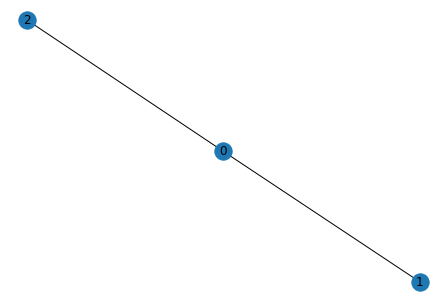

match_branches = []
edges_to_delete (resolve crossover) = [[0, 1], [0, 2], [1, 2]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([0, 1]), array([0, 2]), array([1, 2])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {0}
Comp 1 = {1}
Comp 2 = {2}
curr_limb_copy.deleted_edges = [array([0, 1]), array([0, 2]), array([1, 2])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([0, 1]), array([0, 2]), array([1, 2])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection


---- working on disconnecting 0 and 2
---- This disconnects S0_0 from S0_2  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIR

  Edge: [1 2]: curr_angle = 162.9

Total time for doubling_back = 0.03451848030090332
There were 1 edges that passed doubling back threshold of 80
Winning edge [1 2] had a doubling back of 162.90216271419578
***inside resolve crossover!!!!****
coordinate_branches = [0, 1, 2]
0 = red
1 = aqua
2 = purple
Angle between 0 and 1 = 17.75 
Angle between 0 and 2 = 75.73 
Angle between 1 and 2 = 121.94 
Final Matches = [[0, 1]]
matched_branches_revised = [[0, 1]]
Original graph


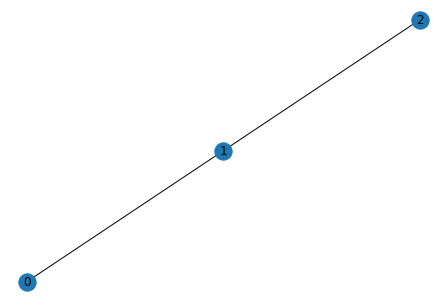

match_branches = [[0, 1]]
edges_to_delete (resolve crossover) = [[0, 2], [1, 2]]
edges_to_create (resolve crossover) = [[0, 1]]
edges_to_delete (cut_limb_network) = [array([0, 2]), array([1, 2])]
edges_to_create = [[0, 1]]
Number of connected components = 2
Comp 0 = {2}
Comp 1 = {0, 1}
curr_limb_copy.deleted_edges = [array([0, 2]), array([1, 2])]
curr_limb_copy.created_edges = [[0, 1]]
After get best cut: cut_edges = [array([0, 2]), array([1, 2])], added_edges = [[0, 1]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([2]), array([0, 1])]


 -------- Working on limb 2------------
Starting combinations to process = [[1 2]]


---- working on disconnecting 1 and 2
---- This disconnects S0_1 from S0_0  
 Cut iterat

  Edge: [1 2]: curr_angle = 98.04

Total time for doubling_back = 0.033807992935180664
There were 1 edges that passed doubling back threshold of 80
Winning edge [1 2] had a doubling back of 98.03701820375827
***inside resolve crossover!!!!****
coordinate_branches = [0, 1, 2]
0 = red
1 = aqua
2 = purple
Angle between 0 and 1 = 33.4 
Angle between 0 and 2 = 70.63 
Angle between 1 and 2 = 87.89 
Final Matches = [[0, 1]]
matched_branches_revised = [[0, 1]]
Original graph


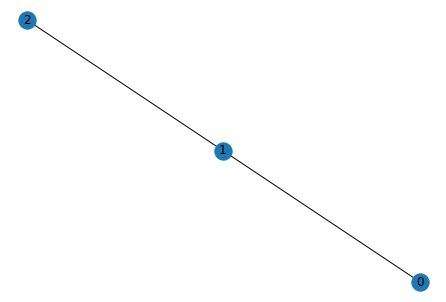

match_branches = [[0, 1]]
edges_to_delete (resolve crossover) = [[0, 2], [1, 2]]
edges_to_create (resolve crossover) = [[0, 1]]
edges_to_delete (cut_limb_network) = [array([0, 2]), array([1, 2])]
edges_to_create = [[0, 1]]
Number of connected components = 2
Comp 0 = {2}
Comp 1 = {0, 1}
curr_limb_copy.deleted_edges = [array([0, 2]), array([1, 2])]
curr_limb_copy.created_edges = [[0, 1]]
After get best cut: cut_edges = [array([0, 2]), array([1, 2])], added_edges = [[0, 1]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([2]), array([0, 1])]
n_paths_cut = 3
using precomputed split suggestions


---Working on Splitting Limb 0 with 1 components----


----Working on seperate_graph 0----
There were more not exactly on



---------Working on soma_idx = 0, soma_group_idx 0, endpt = [1270829.72727273  402914.8         700758.75454545]---------
Starting_edge inside branches_to_conept = [[1269700.37988441  402354.57942026  699153.03352923]
 [1270829.72727273  402914.8         700758.75454545]]
Done generating concept network 


Concept graph size was 1 or less so returning original


----Working on seperate_graph 1----


---------Working on soma_idx = 0, soma_group_idx 0, endpt = [1270750.22727273  405005.48636364  701570.55454545]---------
Starting_edge inside branches_to_conept = [[1269700.37988441  402354.57942026  699153.03352923]
 [1270750.22727273  405005.48636364  701570.55454545]]
At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [2]
printing out current edge:
[[1270750.22727273  405005.48636364  701570.55454545]
 [1269700.37988441  402354.57942026  699153.03352923]]
edge_endpoints_to_process was empty so exiting loop after 2 iterations
starting_node 

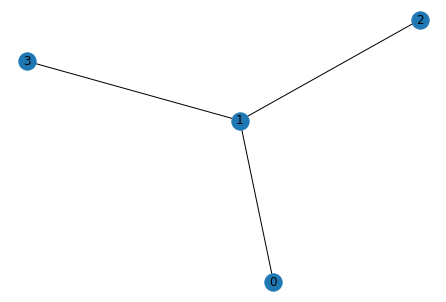

match_branches = [[1, 3]]
edges_to_delete (resolve crossover) = [[0, 1], [0, 2], [0, 3], [1, 2], [2, 3]]
edges_to_create (resolve crossover) = [[1, 3]]
curr_limb.deleted_edges 5 =[]
nx.number_connected_components(G) before = 1
G.edges() = []
G.nodes() = [1, 2]
nx.number_connected_components(G) after = 2
Using the resolve crossover delete edges because will help seperate the path
Skipping endnode 1 because skeletal distance was 2079.7353651299577 and threshold was 2500
Skipping endnode 2 because skeletal distance was 1569.6681888895532 and threshold was 2500
Could not used the revised endnodes path because empty
skip_nodes = []
edges_to_delete (cut_limb_network) = [[0, 1], [0, 2], [0, 3], [1, 2], [2, 3]]
edges_to_create = [[1, 3]]
Number of connected components = 3
Comp 0 = {2}
Comp 1 = {0}
Comp 2 = {1, 3}
curr_limb_copy.deleted_edges = [[0, 1], [0, 2], [0, 3], [1, 2], [2, 3]]
curr_limb_copy.created_edges = [[1, 3]]
After get best cut: cut_edges = [[0, 1], [0, 2], [0, 3], [1, 2], [2, 3]

  Edge: [6 4]: curr_angle = 71.58

Total time for doubling_back = 0.03414034843444824

Attempting the width jump check (ARTIFICIALLY ATTEMPTING FROM BOTH SIDES)
width_jump_threshold = 200
  Edge: [6 4]: jump = 1316.44
Adding error edge [6 4] because width jump was 1316.444720645327
Total time for width = 0.010832071304321289
Did not find an error edge in either of the paths
Number of connected components = 1
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
curr_limb_copy.deleted_edges = []
curr_limb_copy.created_edges = []
After get best cut: cut_edges = None, added_edges = []
***** there was no suggested cut for this limb even though it is still connnected***


---- working on disconnecting 6 and 9
---- This disconnects S0_2 from S0_0  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 1
Total number of graphs at the end of the split AFTER DIRECTIONAL = 1
Shortest path = [6, 5, 9]

 --------- START OF GET BEST EDGE --------- 
curr_limb.deleted_edges=[

  Edge: [6 5]: curr_angle = 49.24

Total time for doubling_back = 0.032872915267944336

Attempting the width jump check (ARTIFICIALLY ATTEMPTING FROM BOTH SIDES)
width_jump_threshold = 200
  Edge: [6 5]: jump = -844.97
Total time for width = 0.010560035705566406
Did not find an error edge in either of the paths
Number of connected components = 1
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
curr_limb_copy.deleted_edges = []
curr_limb_copy.created_edges = []
After get best cut: cut_edges = None, added_edges = []
***** there was no suggested cut for this limb even though it is still connnected***


---- working on disconnecting 6 and 10
---- This disconnects S0_2 from S0_3  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 1
Total number of graphs at the end of the split AFTER DIRECTIONAL = 1
Shortest path = [6, 4, 2, 3, 10]

 --------- START OF GET BEST EDGE --------- 
curr_limb.deleted_edges=[]
consider_path_neighbors_for_removal is set so segments

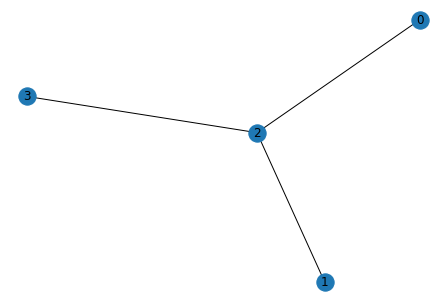

match_branches = [[1, 2], [0, 3]]
edges_to_delete (resolve crossover) = [[0, 1], [0, 2], [1, 3], [2, 3]]
edges_to_create (resolve crossover) = [[1, 2], [0, 3]]
curr_limb.deleted_edges 5 =[]
nx.number_connected_components(G) before = 1
G.edges() = [(6, 4), (4, 2), (3, 10)]
G.nodes() = [6, 4, 2, 3, 10]
nx.number_connected_components(G) after = 2
Using the resolve crossover delete edges because will help seperate the path
Skipping endnode 10 because skeletal distance was 2330.7252617497643 and threshold was 2500
skip_nodes = [10]
edges_to_delete (cut_limb_network) = [[0, 1], [0, 2], [1, 3], [2, 3]]
edges_to_create = [[1, 2], [0, 3]]
Number of connected components = 2
Comp 0 = {1, 2, 4, 5, 6, 7, 8, 9}
Comp 1 = {0, 11, 10, 3}
curr_limb_copy.deleted_edges = [[0, 1], [0, 2], [1, 3], [2, 3]]
curr_limb_copy.created_edges = [[1, 2], [0, 3]]
After get best cut: cut_edges = [[0, 1], [0, 2], [1, 3], [2, 3]], added_edges = [[1, 2], [0, 3]]
total_soma_paths_to_cut = []
-----------counter = 0---------

  Edge: [4 5]: curr_angle = 90.79

Total time for doubling_back = 0.03367304801940918
There were 1 edges that passed doubling back threshold of 80
Winning edge [4 5] had a doubling back of 90.79102110347799
***inside resolve crossover!!!!****
coordinate_branches = [4, 5, 6]
4 = red
5 = aqua
6 = purple
Angle between 4 and 5 = 98.88 
Angle between 4 and 6 = 54.5 
Angle between 5 and 6 = 34.8 
Final Matches = [[5, 6]]
matched_branches_revised = [[5, 6]]
Original graph


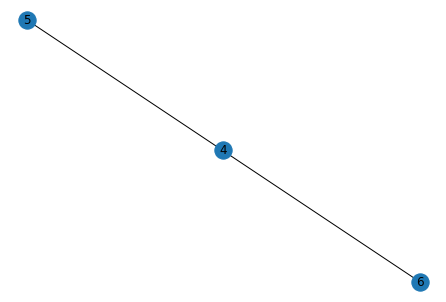

match_branches = [[5, 6]]
edges_to_delete (resolve crossover) = [[4, 5], [4, 6]]
edges_to_create (resolve crossover) = [[5, 6]]
edges_to_delete (cut_limb_network) = [array([4, 5]), array([4, 6])]
edges_to_create = [[5, 6]]
Number of connected components = 3
Comp 0 = {9, 5, 6, 7}
Comp 1 = {8, 1, 2, 4}
Comp 2 = {0, 11, 10, 3}
curr_limb_copy.deleted_edges = [[0, 1], [0, 2], [1, 3], [2, 3], array([4, 5]), array([4, 6])]
curr_limb_copy.created_edges = [[1, 2], [0, 3], [5, 6]]
After get best cut: cut_edges = [array([4, 5]), array([4, 6])], added_edges = [[5, 6]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection


---- working on disconnecting 8 and 10
---- This disconnects S0_1 from S0_3  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
T

At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [7]
printing out current edge:
[[ 788058.1147541   809613.11639344 1092211.72131148]
 [ 786838.          810704.         1092700.        ]]
edge_endpoints_to_process was empty so exiting loop after 12 iterations
starting_node in concept map (that should match the starting edge) = 9
Total time for branches to concept conversion = 0.07056736946105957

Done generating concept network 




---------Working on soma_idx = 0, soma_group_idx 1, endpt = [ 787158.2546875  807403.3484375 1090890.3125   ]---------
Starting_edge inside branches_to_conept = [[ 785300.         807608.        1091000.       ]
 [ 787158.2546875  807403.3484375 1090890.3125   ]]
At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [6]
printing out current edge:
[[ 787158.2546875  807403.3484375 1090890.3125   ]
 [ 785300.         807608.        1091000.       ]]
edge_endpoints_to_p


Total time for neuron instance creation = 7.79173731803894


Number of seperate neuron objects = 1
neuron_list = [<neuron.Neuron object at 0x7fedfdce9240>]
neuron_list_errored_limbs_area = [[]]
neuron_list_n_multi_soma_errors = [0]
neuron_list_n_same_soma_errors = [0]
Number of neurons: 1
split_success = 0
largest_n_faces = 17080
largest_volume = 0.0
Saving Neuorn in suppress_output mode...please wait
Saved File at location: /mnt/dj-stor01/platinum/minnie65/02/decomposition/864691134826321585_0_25_soma_0_split
Save time = 0.10836505889892578


 ------ Total time for 864691134826321585 = 15.618100881576538 ------



---- Working on Neuron 864691134827296867 ----
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = [0]


 -------- Working on limb 0------------
Starting combinations to process = [[1 3]]


---- working on disconnecting 1 and 3
---- This disconnects S0_0 from S0_1  
 Cut iteration 0
Total number of graphs at the end of the spl

No skeletons to stack so returning empty list
No upstream skeletons so doing backup
  Edge: [1 2]: curr_angle = 103.69
  Edge: [2 3]: curr_angle = 141.93

Total time for doubling_back = 0.04631757736206055
There were 2 edges that passed doubling back threshold of 80
Winning edge [2 3] had a doubling back of 141.9252430012145
***inside resolve crossover!!!!****
coordinate_branches = [2, 3, 4]
2 = red
3 = aqua
4 = purple
Angle between 2 and 3 = 89.91 
Angle between 2 and 4 = 8.87 
Angle between 3 and 4 = 84.11 
Final Matches = [[2, 4]]
matched_branches_revised = [[2, 4]]
Original graph


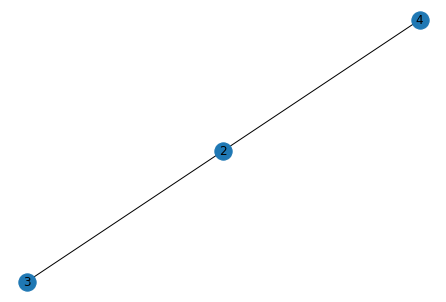

match_branches = [[2, 4]]
edges_to_delete (resolve crossover) = [[2, 3], [3, 4]]
edges_to_create (resolve crossover) = [[2, 4]]
edges_to_delete (cut_limb_network) = [array([2, 3]), array([3, 4])]
edges_to_create = [[2, 4]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 4}
Comp 1 = {3}
curr_limb_copy.deleted_edges = [array([2, 3]), array([3, 4])]
curr_limb_copy.created_edges = [[2, 4]]
After get best cut: cut_edges = [array([2, 3]), array([3, 4])], added_edges = [[2, 4]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([0, 1, 2, 4]), array([3])]
n_paths_cut = 1
using precomputed split suggestions


---Working on Splitting Limb 0 with 2 components----


----Working on seperate_graph 0----


---------Working

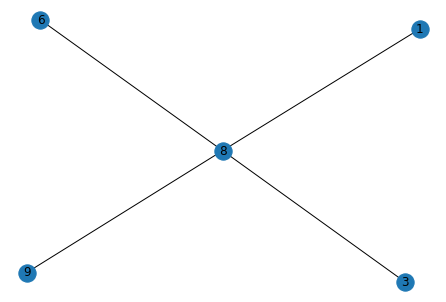

match_branches = [[6, 9]]
edges_to_delete (resolve crossover) = [[1, 3], [1, 6], [1, 8], [1, 9], [3, 6], [3, 8], [3, 9], [6, 8], [8, 9]]
edges_to_create (resolve crossover) = [[6, 9]]
curr_limb.deleted_edges 5 =[]
nx.number_connected_components(G) before = 1
G.edges() = [(0, 8)]
G.nodes() = [0, 8, 1]
nx.number_connected_components(G) after = 2
Using the resolve crossover delete edges because will help seperate the path
skip_nodes = []
edges_to_delete (cut_limb_network) = [[1, 3], [1, 6], [1, 8], [1, 9], [3, 6], [3, 8], [3, 9], [6, 8], [8, 9]]
edges_to_create = [[6, 9]]
Number of connected components = 4
Comp 0 = {0, 7, 8, 12, 13}
Comp 1 = {1}
Comp 2 = {3}
Comp 3 = {2, 4, 5, 6, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21}
curr_limb_copy.deleted_edges = [[1, 3], [1, 6], [1, 8], [1, 9], [3, 6], [3, 8], [3, 9], [6, 8], [8, 9]]
curr_limb_copy.created_edges = [[6, 9]]
After get best cut: cut_edges = [[1, 3], [1, 6], [1, 8], [1, 9], [3, 6], [3, 8], [3, 9], [6, 8], [8, 9]], added_edges = [[6, 9]

  Edge: [2 4]: curr_angle = 151.68

Total time for doubling_back = 0.036195993423461914
There were 1 edges that passed doubling back threshold of 80
Winning edge [2 4] had a doubling back of 151.6790339197342
***inside resolve crossover!!!!****
coordinate_branches = [2, 3, 4]
2 = red
3 = aqua
4 = purple
Angle between 2 and 3 = 75.94 
Angle between 2 and 4 = 177.28 
Angle between 3 and 4 = 74.42 
Final Matches = []
matched_branches_revised = []
Original graph


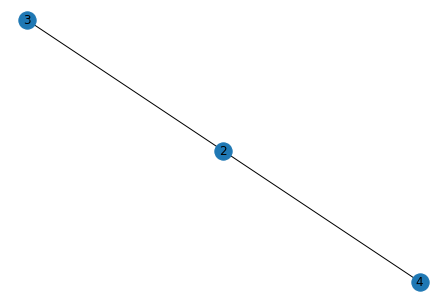

match_branches = []
edges_to_delete (resolve crossover) = [[2, 3], [2, 4], [3, 4]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([2, 3]), array([2, 4]), array([3, 4])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {0, 1, 2}
Comp 1 = {3}
Comp 2 = {4}
curr_limb_copy.deleted_edges = [array([2, 3]), array([2, 4]), array([3, 4])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([2, 3]), array([2, 4]), array([3, 4])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 3: [array([0, 1, 2]), array([3]), array([4])]
n_paths_cut = 2
using precomputed split suggestions


---Working on Splitting Limb 0 with 1 components----


----Working 

local_floating_meshes = []
Already have preprocessed data
--- 1) Finished unpacking preprocessed materials: 7.987022399902344e-05
total_edges = [['S0', 'L0'], ['S0', 'L1'], ['S0', 'L2'], ['S0', 'L3']]
--- 2) Finished creating neuron connectivity graph: 0.0001232624053955078
Having to generate soma_meshes_face_idx because none in preprocessed data
--- 3a) Finshed generating soma_meshes_face_idx: 0.017225265502929688
Using precomputed volume ratio
--- 3) Finshed generating soma objects and adding them to concept graph: 7.19789981842041
Using already existing limb_mehses_face_idx in preprocessed data 
curr_limb_concept_networks= {0: [<networkx_utils.GraphOrderedEdges object at 0x7fedf76e8748>]}
curr_limb_concept_networks= {0: [<networkx_utils.GraphOrderedEdges object at 0x7fedf76e81d0>]}
curr_limb_concept_networks= {0: [<networkx_utils.GraphOrderedEdges object at 0x7fedf76e8198>]}
curr_limb_concept_networks= {0: [<networkx_utils.GraphOrderedEdges object at 0x7fedf7da8828>]}
Concept graph 

  Edge: [0 1]: curr_angle = 108.4

Total time for doubling_back = 0.11016011238098145
There were 1 edges that passed doubling back threshold of 80
Winning edge [0 1] had a doubling back of 108.39838693355948
***inside resolve crossover!!!!****
coordinate_branches = [0, 1, 2]
0 = red
1 = aqua
2 = purple
Angle between 0 and 1 = 120.78 
Angle between 0 and 2 = 69.6 
Angle between 1 and 2 = 59.78 
Final Matches = []
matched_branches_revised = []
Original graph


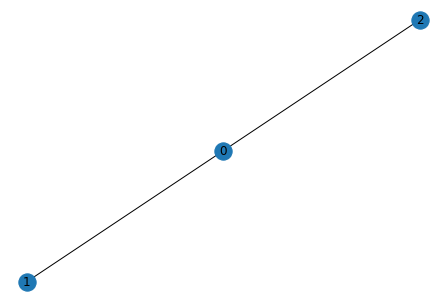

match_branches = []
edges_to_delete (resolve crossover) = [[0, 1], [0, 2], [1, 2]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([0, 1]), array([0, 2]), array([1, 2])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {0}
Comp 1 = {1}
Comp 2 = {2}
curr_limb_copy.deleted_edges = [array([0, 1]), array([0, 2]), array([1, 2])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([0, 1]), array([0, 2]), array([1, 2])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 3: [array([0]), array([1]), array([2])]
n_paths_cut = 1
using precomputed split suggestions


---Working on Splitting Limb 0 with 3 components----


----Working on seperate_

No skeletons to stack so returning empty list
No upstream skeletons so doing backup
  Edge: [0 1]: curr_angle = 95.98

Total time for doubling_back = 0.041533470153808594
There were 1 edges that passed doubling back threshold of 80
Winning edge [0 1] had a doubling back of 95.97684881587567
***inside resolve crossover!!!!****
coordinate_branches = [0, 1, 2]
0 = red
1 = aqua
2 = purple
Angle between 0 and 1 = 99.31 
Angle between 0 and 2 = 98.81 
Angle between 1 and 2 = 32.1 
Final Matches = [[1, 2]]
matched_branches_revised = [[1, 2]]
Original graph


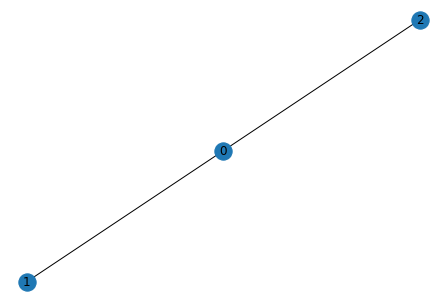

match_branches = [[1, 2]]
edges_to_delete (resolve crossover) = [[0, 1], [0, 2]]
edges_to_create (resolve crossover) = [[1, 2]]
edges_to_delete (cut_limb_network) = [array([0, 1]), array([0, 2])]
edges_to_create = [[1, 2]]
Number of connected components = 2
Comp 0 = {1, 2}
Comp 1 = {0}
curr_limb_copy.deleted_edges = [array([0, 1]), array([0, 2])]
curr_limb_copy.created_edges = [[1, 2]]
After get best cut: cut_edges = [array([0, 1]), array([0, 2])], added_edges = [[1, 2]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([1, 2]), array([0])]
n_paths_cut = 1
using precomputed split suggestions


---Working on Splitting Limb 0 with 2 components----


----Working on seperate_graph 0----


---------Working on soma_idx


segment_name before cgal = L0_2



Total time for neuron instance creation = 7.859906196594238


Number of seperate neuron objects = 1
neuron_list = [<neuron.Neuron object at 0x7fedfc0d47b8>]
neuron_list_errored_limbs_area = [[]]
neuron_list_n_multi_soma_errors = [0]
neuron_list_n_same_soma_errors = [0]
Number of neurons: 1
split_success = 0
largest_n_faces = 14704
largest_volume = 106.22547997908333
Saving Neuorn in suppress_output mode...please wait
Saved File at location: /mnt/dj-stor01/platinum/minnie65/02/decomposition/864691134833545654_0_25_soma_0_split
Save time = 0.15539813041687012


 ------ Total time for 864691134833545654 = 16.00000286102295 ------



---- Working on Neuron 864691134834082058 ----
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = [0]


 -------- Working on limb 0------------
Starting combinations to process = [[0 3]
 [0 4]
 [3 4]]


---- working on disconnecting 0 and 3
---- This disconnects S0_1 from S0_2  
 Cut iteration 0
Total number of

  Edge: [0 2]: curr_angle = 104.01

Total time for doubling_back = 0.034096717834472656
There were 1 edges that passed doubling back threshold of 80
Winning edge [0 2] had a doubling back of 104.00557603048425
***inside resolve crossover!!!!****
coordinate_branches = [0, 1, 2]
0 = red
1 = aqua
2 = purple
Angle between 0 and 1 = 98.85 
Angle between 0 and 2 = 106.46 
Angle between 1 and 2 = 61.29 
Final Matches = []
matched_branches_revised = []
Original graph


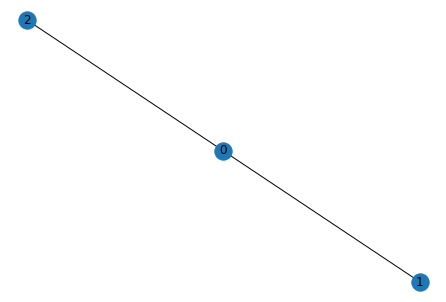

match_branches = []
edges_to_delete (resolve crossover) = [[0, 1], [0, 2], [1, 2]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([0, 1]), array([0, 2]), array([1, 2])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {2, 3, 4}
Comp 1 = {0}
Comp 2 = {1}
curr_limb_copy.deleted_edges = [array([0, 1]), array([0, 2]), array([1, 2])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([0, 1]), array([0, 2]), array([1, 2])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection


---- working on disconnecting 0 and 4
---- This disconnects S0_1 from S0_0  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFT

  Edge: [3 4]: curr_angle = 113.11

Total time for doubling_back = 0.031557559967041016
There were 1 edges that passed doubling back threshold of 80
Winning edge [3 4] had a doubling back of 113.11117225249808
***inside resolve crossover!!!!****
coordinate_branches = [2, 3, 4]
2 = red
3 = aqua
4 = purple
Angle between 2 and 3 = 74.48 
Angle between 2 and 4 = 39.78 
Angle between 3 and 4 = 78.74 
Final Matches = []
matched_branches_revised = []
Original graph


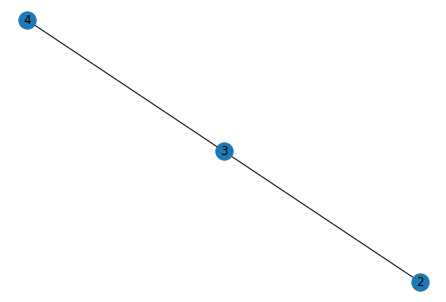

match_branches = []
edges_to_delete (resolve crossover) = [[2, 3], [2, 4], [3, 4]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([2, 3]), array([2, 4]), array([3, 4])]
edges_to_create = []
Number of connected components = 5
Comp 0 = {4}
Comp 1 = {2}
Comp 2 = {3}
Comp 3 = {0}
Comp 4 = {1}
curr_limb_copy.deleted_edges = [array([0, 1]), array([0, 2]), array([1, 2]), array([2, 3]), array([2, 4]), array([3, 4])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([2, 3]), array([2, 4]), array([3, 4])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 5
Total number of graphs at the end of the split AFTER DIRECTIONAL = 5
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 5: [array([4]), array([2]), array([3]), array([0]), array([1])]
n_paths_cut = 2
using precomputed spli

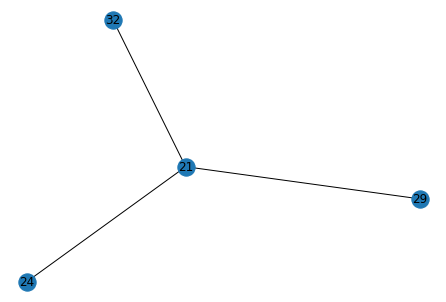

match_branches = [[24, 32]]
edges_to_delete (resolve crossover) = [[21, 24], [21, 29], [21, 32], [24, 29], [29, 32]]
edges_to_create (resolve crossover) = [[24, 32]]
curr_limb.deleted_edges 5 =[]
nx.number_connected_components(G) before = 1
G.edges() = [(19, 21)]
G.nodes() = [19, 21, 29]
nx.number_connected_components(G) after = 2
Using the resolve crossover delete edges because will help seperate the path
skip_nodes = []
edges_to_delete (cut_limb_network) = [[21, 24], [21, 29], [21, 32], [24, 29], [29, 32]]
edges_to_create = [[24, 32]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57}
Comp 1 = {24, 32}
Comp 2 = {29}
curr_limb_copy.deleted_edges = [[21, 24], [21, 29], [21, 32], [24, 29], [29, 32]]
curr_limb_copy.created_edges = [[24, 32]]
After get best cut: cut_edges = [[21, 24], [21

At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [46]
printing out current edge:
[[1458965.71428571 1127353.97142857  990875.11142857]
 [1459821.16857548 1130636.91710954  991001.05124262]]
edge_endpoints_to_process was empty so exiting loop after 58 iterations
starting_node in concept map (that should match the starting edge) = 29
Total time for branches to concept conversion = 0.6113741397857666

Done generating concept network 


Still remaining error limbs ([0.]), but will filter them away


------ Working on Soma 0 -------
limb_neighbors BEFORE error limbs removed = [0, 1]
limb_neighbors AFTER error limbs removed = [1]
curr_n_multi_soma_limbs_cancelled = 0
curr_n_same_soma_limbs_cancelled = 1
n_errored_lims = 1
curr_error_limbs_cancelled_area = [1756.6489582300214]
local_floating_meshes = []
Already have preprocessed data
--- 1) Finished unpacking preprocessed materials: 6.699562072753906e-05
total_edges = [['S0', 'L0']]
--- 2) Finis


Total time for neuron instance creation = 7.903562545776367


Number of seperate neuron objects = 1
neuron_list = [<neuron.Neuron object at 0x7fedf7a4fba8>]
neuron_list_errored_limbs_area = [[1756.6489582300214]]
neuron_list_n_multi_soma_errors = [0]
neuron_list_n_same_soma_errors = [1]
Number of neurons: 1
split_success = 0
largest_n_faces = 19107
largest_volume = 223.6544511398662
Saving Neuorn in suppress_output mode...please wait
Saved File at location: /mnt/dj-stor01/platinum/minnie65/02/decomposition/864691134836870914_0_25_soma_0_split
Save time = 0.13476300239562988


 ------ Total time for 864691134836870914 = 42.449403524398804 ------



---- Working on Neuron 864691134849617820 ----
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = []
n_paths_cut = 0
using precomputed split suggestions


------ Working on Soma 0 -------
limb_neighbors BEFORE error limbs removed = [0]
limb_neighbors AFTER error limbs removed = [0]
curr_n_mult

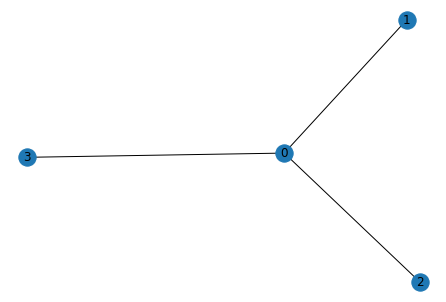

match_branches = [[1, 3]]
edges_to_delete (resolve crossover) = [[0, 1], [0, 2], [0, 3], [1, 2], [2, 3]]
edges_to_create (resolve crossover) = [[1, 3]]
curr_limb.deleted_edges 5 =[]
nx.number_connected_components(G) before = 1
G.edges() = []
G.nodes() = [0, 1]
nx.number_connected_components(G) after = 2
Using the resolve crossover delete edges because will help seperate the path
Skipping endnode 1 because skeletal distance was 1728.3347216722636 and threshold was 2500
Could not used the revised endnodes path because empty
skip_nodes = []
edges_to_delete (cut_limb_network) = [[0, 1], [0, 2], [0, 3], [1, 2], [2, 3]]
edges_to_create = [[1, 3]]
Number of connected components = 3
Comp 0 = {2}
Comp 1 = {0}
Comp 2 = {1, 3}
curr_limb_copy.deleted_edges = [[0, 1], [0, 2], [0, 3], [1, 2], [2, 3]]
curr_limb_copy.created_edges = [[1, 3]]
After get best cut: cut_edges = [[0, 1], [0, 2], [0, 3], [1, 2], [2, 3]], added_edges = [[1, 3]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 

Already have preprocessed data
--- 1) Finished unpacking preprocessed materials: 5.984306335449219e-05
total_edges = []
--- 2) Finished creating neuron connectivity graph: 6.0558319091796875e-05
Having to generate soma_meshes_face_idx because none in preprocessed data
--- 3a) Finshed generating soma_meshes_face_idx: 0.00986170768737793
Using precomputed volume ratio
Did not have S0 in concept network so adding it
--- 3) Finshed generating soma objects and adding them to concept graph: 8.251032590866089
Using already existing limb_mehses_face_idx in preprocessed data 
--- 4) Finshed generating Limb objects and adding them to concept graph: 2.9087066650390625e-05
--- 5) SKIPPING Doing the adaptive mesh correspondence on the meshparty preprocessing ---
--- 6) SKIPPING Using the computed_attribute_dict to populate neuron attributes ---
self.n_limbs = 0
Skipping the width and spine calculation because no limbs
Total time for neuron instance creation = 8.261343955993652


Number of seperate 

  Edge: [3 2]: curr_angle = 68.02
  Edge: [2 4]: curr_angle = 99.74

Total time for doubling_back = 0.05725502967834473
There were 1 edges that passed doubling back threshold of 80
Winning edge [2 4] had a doubling back of 99.74057265393978
***inside resolve crossover!!!!****
coordinate_branches = [0, 2, 4]
0 = red
2 = aqua
4 = purple
Angle between 0 and 2 = 81.99 
Angle between 0 and 4 = 10.85 
Angle between 2 and 4 = 88.43 
Final Matches = [[0, 4]]
matched_branches_revised = [[0, 4]]
Original graph


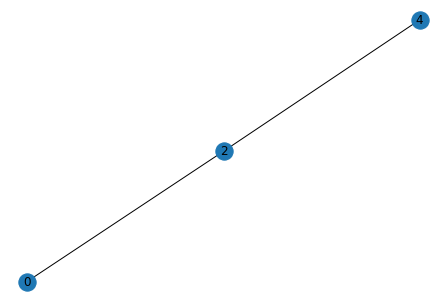

match_branches = [[0, 4]]
edges_to_delete (resolve crossover) = [[0, 2], [2, 4]]
edges_to_create (resolve crossover) = [[0, 4]]
edges_to_delete (cut_limb_network) = [array([0, 2]), array([2, 4])]
edges_to_create = [[0, 4]]
Number of connected components = 2
Comp 0 = {1, 2, 3}
Comp 1 = {0, 4}
curr_limb_copy.deleted_edges = [array([0, 2]), array([2, 4])]
curr_limb_copy.created_edges = [[0, 4]]
After get best cut: cut_edges = [array([0, 2]), array([2, 4])], added_edges = [[0, 4]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([1, 2, 3]), array([0, 4])]
n_paths_cut = 1
using precomputed split suggestions


---Working on Splitting Limb 1 with 2 components----


----Working on seperate_graph 0----


---------Working


segment_name before cgal = L1_1



Total time for neuron instance creation = 7.326830148696899


Number of seperate neuron objects = 1
neuron_list = [<neuron.Neuron object at 0x7fedf7d95ac8>]
neuron_list_errored_limbs_area = [[]]
neuron_list_n_multi_soma_errors = [0]
neuron_list_n_same_soma_errors = [0]
Number of neurons: 1
split_success = 0
largest_n_faces = 11515
largest_volume = 113.69342437092236
Saving Neuorn in suppress_output mode...please wait
Saved File at location: /mnt/dj-stor01/platinum/minnie65/02/decomposition/864691134865303584_0_25_soma_0_split
Save time = 0.1285994052886963


 ------ Total time for 864691134865303584 = 14.494147539138794 ------



---- Working on Neuron 864691134868397058 ----
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = []
n_paths_cut = 0
using precomputed split suggestions


------ Working on Soma 0 -------
limb_neighbors BEFORE error limbs removed = [0, 1, 2, 3, 4]
limb_neighbors AFTER error limbs removed = [0 1 2 3 4]
curr_n_mu

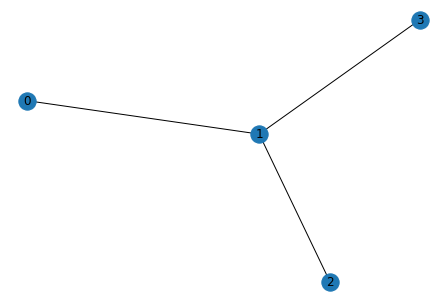

match_branches = [[0, 3]]
edges_to_delete (resolve crossover) = [[0, 1], [0, 2], [1, 2], [1, 3], [2, 3]]
edges_to_create (resolve crossover) = [[0, 3]]
curr_limb.deleted_edges 5 =[]
nx.number_connected_components(G) before = 1
G.edges() = []
G.nodes() = [1, 2]
nx.number_connected_components(G) after = 2
Using the resolve crossover delete edges because will help seperate the path
Skipping endnode 1 because skeletal distance was 1278.5169702474054 and threshold was 2500
Skipping endnode 2 because skeletal distance was 536.6404219045933 and threshold was 2500
Could not used the revised endnodes path because empty
skip_nodes = []
edges_to_delete (cut_limb_network) = [[0, 1], [0, 2], [1, 2], [1, 3], [2, 3]]
edges_to_create = [[0, 3]]
Number of connected components = 3
Comp 0 = {1}
Comp 1 = {0, 3}
Comp 2 = {2}
curr_limb_copy.deleted_edges = [[0, 1], [0, 2], [1, 2], [1, 3], [2, 3]]
curr_limb_copy.created_edges = [[0, 3]]
After get best cut: cut_edges = [[0, 1], [0, 2], [1, 2], [1, 3], [2, 3]]

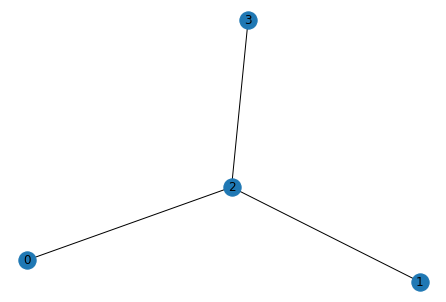

match_branches = [[0, 2]]
edges_to_delete (resolve crossover) = [[0, 1], [0, 3], [1, 2], [1, 3], [2, 3]]
edges_to_create (resolve crossover) = [[0, 2]]
curr_limb.deleted_edges 5 =[]
nx.number_connected_components(G) before = 1
G.edges() = []
G.nodes() = [2, 3]
nx.number_connected_components(G) after = 2
Using the resolve crossover delete edges because will help seperate the path
Skipping endnode 2 because skeletal distance was 1080.2118103017401 and threshold was 2500
Skipping endnode 3 because skeletal distance was 1399.5290927608817 and threshold was 2500
Could not used the revised endnodes path because empty
skip_nodes = []
edges_to_delete (cut_limb_network) = [[0, 1], [0, 3], [1, 2], [1, 3], [2, 3]]
edges_to_create = [[0, 2]]
Number of connected components = 3
Comp 0 = {3}
Comp 1 = {0, 2}
Comp 2 = {1}
curr_limb_copy.deleted_edges = [[0, 1], [0, 3], [1, 2], [1, 3], [2, 3]]
curr_limb_copy.created_edges = [[0, 2]]
After get best cut: cut_edges = [[0, 1], [0, 3], [1, 2], [1, 3], [2, 3]

Saved File at location: /mnt/dj-stor01/platinum/minnie65/02/decomposition/864691134873454082_0_25_soma_0_split
Save time = 0.4334578514099121


 ------ Total time for 864691134873454082 = 16.980348348617554 ------



---- Working on Neuron 864691134873724410 ----
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = [0]


 -------- Working on limb 0------------
Starting combinations to process = [[ 5 10]]


---- working on disconnecting 5 and 10
---- This disconnects S0_1 from S0_0  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 1
Total number of graphs at the end of the split AFTER DIRECTIONAL = 1
Shortest path = [5, 6, 7, 12, 10]

 --------- START OF GET BEST EDGE --------- 
curr_limb.deleted_edges=[]
consider_path_neighbors_for_removal is set so segments_to_consider = [ 3  6  7  8  9 11 12 16]
Short segments to combine = []
Found 1 high degree coordinates to cut
high_degree_endpoint_coordinates_widt

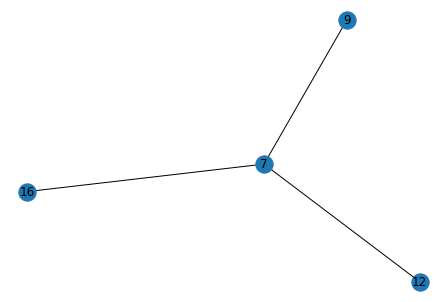

match_branches = [[7, 16]]
edges_to_delete (resolve crossover) = [[7, 9], [7, 12], [9, 12], [9, 16], [12, 16]]
edges_to_create (resolve crossover) = [[7, 16]]
curr_limb.deleted_edges 5 =[]
nx.number_connected_components(G) before = 1
G.edges() = [(5, 6), (6, 7), (12, 10)]
G.nodes() = [5, 6, 7, 12, 10]
nx.number_connected_components(G) after = 2
Using the resolve crossover delete edges because will help seperate the path
Skipping endnode 5 because skeletal distance was 1376.887901619988 and threshold was 2500
skip_nodes = [5]
edges_to_delete (cut_limb_network) = [[7, 9], [7, 12], [9, 12], [9, 16], [12, 16]]
edges_to_create = [[7, 16]]
Number of connected components = 3
Comp 0 = {10, 11, 12, 13, 14}
Comp 1 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 15, 16, 17, 18, 19, 20, 21, 22, 23}
Comp 2 = {9}
curr_limb_copy.deleted_edges = [[7, 9], [7, 12], [9, 12], [9, 16], [12, 16]]
curr_limb_copy.created_edges = [[7, 16]]
After get best cut: cut_edges = [[7, 9], [7, 12], [9, 12], [9, 16], [12, 16]], added_edge

  Edge: [1 2]: curr_angle = 116.76

Total time for doubling_back = 0.026278972625732422
There were 1 edges that passed doubling back threshold of 80
Winning edge [1 2] had a doubling back of 116.76015651893952
***inside resolve crossover!!!!****
coordinate_branches = [1, 2, 3]
1 = red
2 = aqua
3 = purple
Angle between 1 and 2 = 116.76 
Angle between 1 and 3 = 18.52 
Angle between 2 and 3 = 72.73 
Final Matches = [[1, 3]]
matched_branches_revised = [[1, 3]]
Original graph


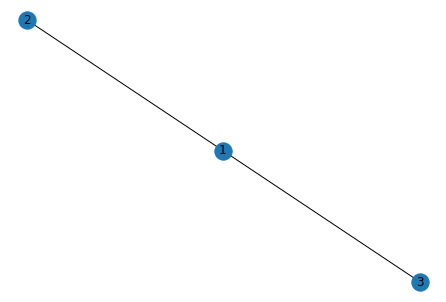

match_branches = [[1, 3]]
edges_to_delete (resolve crossover) = [[1, 2], [2, 3]]
edges_to_create (resolve crossover) = [[1, 3]]
edges_to_delete (cut_limb_network) = [array([1, 2]), array([2, 3])]
edges_to_create = [[1, 3]]
Number of connected components = 2
Comp 0 = {2}
Comp 1 = {0, 1, 3, 4}
curr_limb_copy.deleted_edges = [array([1, 2]), array([2, 3])]
curr_limb_copy.created_edges = [[1, 3]]
After get best cut: cut_edges = [array([1, 2]), array([2, 3])], added_edges = [[1, 3]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([2]), array([0, 1, 3, 4])]
n_paths_cut = 1
using precomputed split suggestions


---Working on Splitting Limb 0 with 2 components----


----Working on seperate_graph 0----


---------Working

  Edge: [3 5]: curr_angle = 69.89

Total time for doubling_back = 0.03285717964172363

Attempting the width jump check (ARTIFICIALLY ATTEMPTING FROM BOTH SIDES)
width_jump_threshold = 200
  Edge: [3 5]: jump = -266.65
Total time for width = 0.006749153137207031
Did not find an error edge in either of the paths
Number of connected components = 1
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}
curr_limb_copy.deleted_edges = []
curr_limb_copy.created_edges = []
After get best cut: cut_edges = None, added_edges = []
***** there was no suggested cut for this limb even though it is still connnected***
Total number of graphs at the end of the split = 1: [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])]


 -------- Working on limb 2------------
Starting combinations to process = [[2 3]]


---- working on disconnecting 2 and 3
---- This disconnects S0_1 from S0_0  
 Cut iteration 0
Total number of graphs at the end of the sp

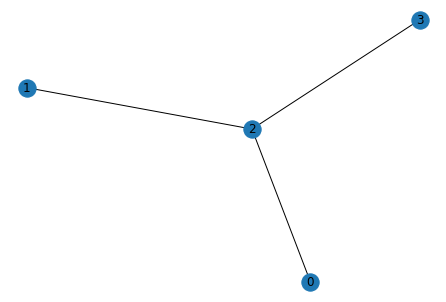

match_branches = [[1, 3]]
edges_to_delete (resolve crossover) = [[0, 1], [0, 2], [0, 3], [1, 2], [2, 3]]
edges_to_create (resolve crossover) = [[1, 3]]
curr_limb.deleted_edges 5 =[]
nx.number_connected_components(G) before = 1
G.edges() = []
G.nodes() = [2, 3]
nx.number_connected_components(G) after = 2
Using the resolve crossover delete edges because will help seperate the path
Skipping endnode 2 because skeletal distance was 1280.6838685685964 and threshold was 2500
Skipping endnode 3 because skeletal distance was 1884.2581490928817 and threshold was 2500
Could not used the revised endnodes path because empty
skip_nodes = []
edges_to_delete (cut_limb_network) = [[0, 1], [0, 2], [0, 3], [1, 2], [2, 3]]
edges_to_create = [[1, 3]]
Number of connected components = 3
Comp 0 = {1, 3}
Comp 1 = {0}
Comp 2 = {2}
curr_limb_copy.deleted_edges = [[0, 1], [0, 2], [0, 3], [1, 2], [2, 3]]
curr_limb_copy.created_edges = [[1, 3]]
After get best cut: cut_edges = [[0, 1], [0, 2], [0, 3], [1, 2], [2, 3]

At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [4]
printing out current edge:
[[1155179.12403101 1067251.36434109  769833.2751938 ]
 [1156020.36541259 1064681.82195808  768622.37097324]]
edge_endpoints_to_process was empty so exiting loop after 19 iterations
starting_node in concept map (that should match the starting edge) = 3
Total time for branches to concept conversion = 0.23440146446228027

Done generating concept network 




---------Working on soma_idx = 0, soma_group_idx 1, endpt = [1158697.66666667 1066201.16666667  769360.91666667]---------
Starting_edge inside branches_to_conept = [[1157493.50766193 1064773.85876902  768145.41317054]
 [1158697.66666667 1066201.16666667  769360.91666667]]
At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [9]
printing out current edge:
[[1158697.66666667 1066201.16666667  769360.91666667]
 [1157493.50766193 1064773.85876902  768145.41317054]]
edge

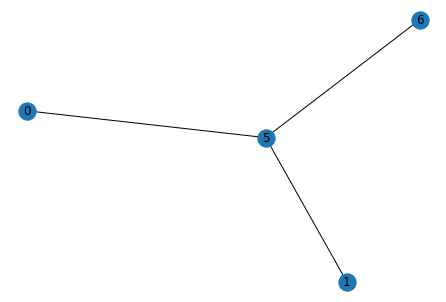

match_branches = [[0, 6]]
edges_to_delete (resolve crossover) = [[0, 1], [0, 5], [1, 5], [1, 6], [5, 6]]
edges_to_create (resolve crossover) = [[0, 6]]
curr_limb.deleted_edges 5 =[]
nx.number_connected_components(G) before = 1
G.edges() = []
G.nodes() = [5, 6]
nx.number_connected_components(G) after = 2
Using the resolve crossover delete edges because will help seperate the path
Skipping endnode 6 because skeletal distance was 1735.6802607963837 and threshold was 2500
Could not used the revised endnodes path because empty
skip_nodes = []
edges_to_delete (cut_limb_network) = [[0, 1], [0, 5], [1, 5], [1, 6], [5, 6]]
edges_to_create = [[0, 6]]
Number of connected components = 3
Comp 0 = {0, 6}
Comp 1 = {1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
Comp 2 = {5}
curr_limb_copy.deleted_edges = [[0, 1], [0, 5], [1, 5], [1, 6], [5, 6]]
curr_limb_copy.created_edges = [[0, 6]]
After get best cut: cut_edges = [[0, 1], [0, 5], [1, 5], [1, 6],

Saved File at location: /mnt/dj-stor01/platinum/minnie65/02/decomposition/864691134874408013_0_25_soma_0_split
Save time = 0.4233520030975342


 ------ Total time for 864691134874408013 = 18.084534168243408 ------



---- Working on Neuron 864691134874936141 ----
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = [1]
multi_touch_limbs = [2]


 -------- Working on limb 1------------
Starting combinations to process = []
Total number of graphs at the end of the split = 1: [array([0])]


 -------- Working on limb 2------------
Starting combinations to process = [[0 1]]


---- working on disconnecting 0 and 1
---- This disconnects S1_0 from S1_1  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 1
Total number of graphs at the end of the split AFTER DIRECTIONAL = 1
Shortest path = [0, 1]

 --------- START OF GET BEST EDGE --------- 
curr_limb.deleted_edges=[]
consider_path_neighbors_for_removal is set so segments_to_consider = [

No skeletons to stack so returning empty list
No upstream skeletons so doing backup
  Edge: [0 1]: curr_angle = 99.19

Total time for doubling_back = 0.03557252883911133
There were 1 edges that passed doubling back threshold of 80
Winning edge [0 1] had a doubling back of 99.1879419891828
***inside resolve crossover!!!!****
coordinate_branches = [0, 1, 2]
0 = red
1 = aqua
2 = purple
Angle between 0 and 1 = 82.15 
Angle between 0 and 2 = 15.5 
Angle between 1 and 2 = 83.54 
Final Matches = [[0, 2]]
matched_branches_revised = [[0, 2]]
Original graph


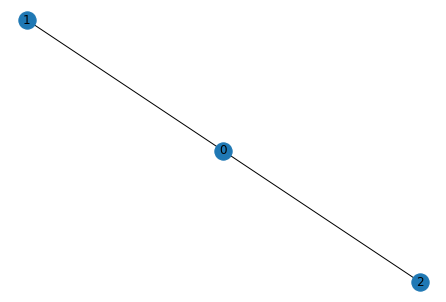

match_branches = [[0, 2]]
edges_to_delete (resolve crossover) = [[0, 1], [1, 2]]
edges_to_create (resolve crossover) = [[0, 2]]
edges_to_delete (cut_limb_network) = [array([0, 1]), array([1, 2])]
edges_to_create = [[0, 2]]
Number of connected components = 2
Comp 0 = {0, 2}
Comp 1 = {1}
curr_limb_copy.deleted_edges = [array([0, 1]), array([1, 2])]
curr_limb_copy.created_edges = [[0, 2]]
After get best cut: cut_edges = [array([0, 1]), array([1, 2])], added_edges = [[0, 2]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([0, 2]), array([1])]
n_paths_cut = 1
using precomputed split suggestions
Concept graph size was 1 or less so returning original


---Working on Splitting Limb 1 with 1 components----


----Working

local_floating_meshes = []
Already have preprocessed data
--- 1) Finished unpacking preprocessed materials: 7.152557373046875e-05
total_edges = [['S0', 'L0']]
--- 2) Finished creating neuron connectivity graph: 9.5367431640625e-05
Having to generate soma_meshes_face_idx because none in preprocessed data
--- 3a) Finshed generating soma_meshes_face_idx: 0.014697074890136719
Using precomputed volume ratio
The watertight method poisson could not run so not closing mesh
--- 3) Finshed generating soma objects and adding them to concept graph: 2.6229395866394043
Using already existing limb_mehses_face_idx in preprocessed data 
curr_limb_concept_networks= {0: [<networkx_utils.GraphOrderedEdges object at 0x7fedfd2c63c8>]}
--- 4) Finshed generating Limb objects and adding them to concept graph: 0.03925156593322754
--- 5) SKIPPING Doing the adaptive mesh correspondence on the meshparty preprocessing ---
--- 6) SKIPPING Using the computed_attribute_dict to populate neuron attributes ---
self.n_lim

KeyboardInterrupt: 

In [12]:
import time
import random
pru = reload(pru)
nru = reload(nru)
import neuron
neuron = reload(neuron)

start_time = time.time()
if not test_mode:
    time.sleep(random.randint(0, 800))
print('Populate Started')
if not test_mode:
    DecompositionSplit.populate(reserve_jobs=True, suppress_errors=True)
else:
    DecompositionSplit.populate(reserve_jobs=True, suppress_errors=False)
print('Populate Done')

print(f"Total time for DecompositionSplit populate = {time.time() - start_time}")